In [12]:
### Library Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [13]:
### Load in Stock Data
def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if isinstance(tickers, str):
        tickers = [tickers]
        
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date)['Adj Close']
        
    # Reset index to make headings in the same row
    data.reset_index(inplace=True)
    # Convert values in date col to dt
    data['Date'] = pd.to_datetime(data['Date'])

    return data

# Function Call
forex_pairs = ['EURUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'AUDUSD=X']
start_date = '2022-01-01'
forex_data = import_stock_data(forex_pairs, start_date)
forex_data.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,EURUSD=X,GBPUSD=X,JPYUSD=X,AUDUSD=X
635,2024-06-10,1.077888,1.272945,0.006376,0.658271
636,2024-06-11,1.076426,1.272637,0.006368,0.660895
637,2024-06-12,1.074033,1.274048,0.006365,0.660770
638,2024-06-13,1.081315,1.279623,0.006378,0.666290
639,2024-06-14,1.069976,1.268022,0.006362,0.661463


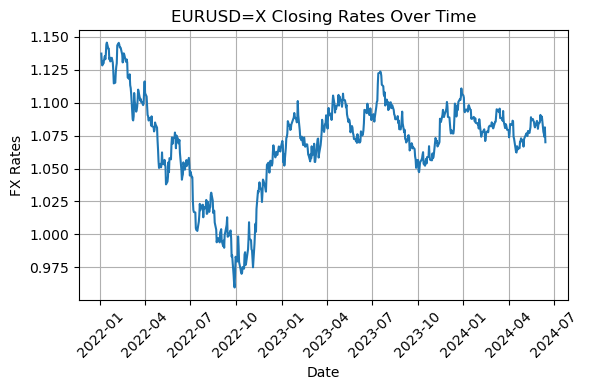

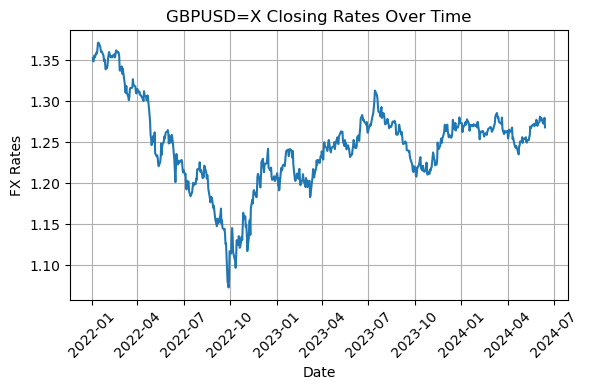

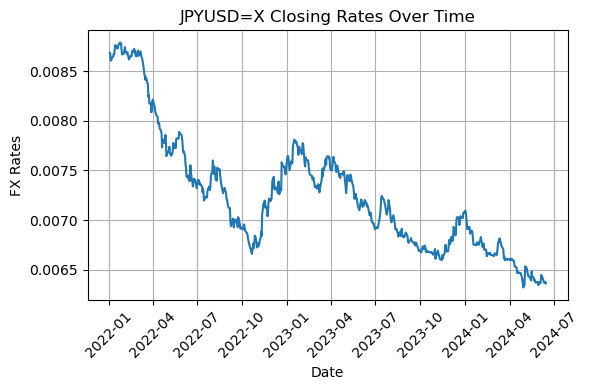

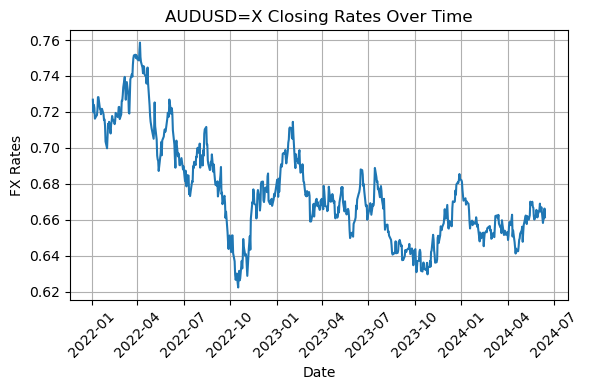

In [14]:
### Plot FX Data
def plot_forex(df, forex_pairs):
    # Create Loop to Plot Each Individual FX Pair
    for pair in forex_pairs:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[pair]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(pair + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

plot_forex(forex_data, forex_pairs)

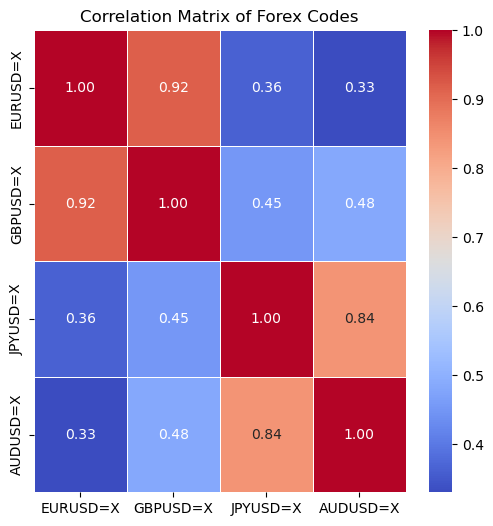

In [15]:
### Correlation Matrix - Heat Map
def corr_matrix(df):
    df = df.drop(['Date'], axis = 1)
    correlation_matrix = df.corr()
    # Create the day Data heatmap using seaborn
    plt.figure(figsize = (6, 6))
    sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
    plt.title('Correlation Matrix of Forex Codes')
    plt.show()

# Create and display the correlation matrix heatmap
corr_matrix(forex_data)

In [18]:
### Compute Stacked Correlation
def stacked_corr(df):
    # Compute the correlation matrix of the DataFrame
    corr_matrix = df.corr()
    # Stack the correlation matrix to convert it into a Series
    stacked_corr = corr_matrix.stack()
    # Filter out correlation values = 1 (self-correlation)
    filtered_corr = stacked_corr[stacked_corr < 1]
    # Sort the correlations in descending order
    sorted_corr = filtered_corr.sort_values(ascending=False)

    return sorted_corr

# Return Stacked Correlation -> Chose the forex pairs that are the most correlated (top of the list)
stacked_correlations = stacked_corr(forex_data)
print(stacked_correlations.head(5))

EURUSD=X  GBPUSD=X    0.918670
GBPUSD=X  EURUSD=X    0.918670
JPYUSD=X  AUDUSD=X    0.843069
AUDUSD=X  JPYUSD=X    0.843069
GBPUSD=X  AUDUSD=X    0.483983
dtype: float64


In [16]:
# Calculate daily returns
forex_data.set_index('Date', inplace=True)
returns = forex_data.pct_change().dropna()

# Calculate the 95% Value at Risk (VaR) for each currency pair
# When EURUSD=X: -0.008645, that means with 95% confidence, the most that the EURUSD rate is expected to 
# lose in one day is approximately 0.8645% of its value.
VaR = returns.quantile(0.05)
print("Value at Risk (95% Confidence level):\n", VaR)

Value at Risk (95% Confidence level):
 EURUSD=X   -0.008708
GBPUSD=X   -0.009976
JPYUSD=X   -0.010292
AUDUSD=X   -0.011860
Name: 0.05, dtype: float64


In [17]:
### Compute Hedge Ratio
